# Predicting particulate matter PM2 2.5 using machine learning

## Step 0: Data Preparation for modeling 
- Load data 
- Dealing with missing data 
- EDA 
- Class definitions, if PM2.5 is less than 10 then class 1, if more than 10 then class 0 
 

In [31]:
## import dependencies 

%matplotlib inline  
import pandas as pd
import numpy as np
import seaborn as sns
from pandas import Grouper

import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier 

from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import auc
from sklearn.model_selection import GridSearchCV

In [32]:
#Load the data
df_Kensing = pd.read_csv('~/Downloads/Air-Quality-Data-SQUARES/2554737734-London_Kensington.csv', parse_dates=[['Date', 'Time']])
#Check first 5 rows
df_Kensing.head()

,Date_Time,Ozone,Status,Nitric oxide,Status.1,Nitrogen dioxide,Status.2,Nitrogen oxides as nitrogen dioxide,Status.3,Sulphur dioxide,...,Unnamed: 151,Unnamed: 152,Unnamed: 153,Unnamed: 154,Unnamed: 155,Unnamed: 156,Unnamed: 157,Unnamed: 158,Unnamed: 159,Unnamed: 160
0,1/1/20 1:00:00,1.1309,V ugm-3,12.08422,V ugm-3,46.22164,V ugm-3,64.75051,V ugm-3,No data,...,NaN,No data,NaN,No data,NaN,No data,NaN,No data,NaN,No data
1,1/1/20 2:00:00,1.19742,V ugm-3,18.95739,V ugm-3,45.01138,V ugm-3,74.07898,V ugm-3,No data,...,NaN,No data,NaN,No data,NaN,No data,NaN,No data,NaN,No data
2,1/1/20 3:00:00,1.49678,V ugm-3,12.43237,V ugm-3,41.43513,V ugm-3,60.49783,V ugm-3,No data,...,NaN,No data,NaN,No data,NaN,No data,NaN,No data,NaN,No data
3,1/1/20 4:00:00,1.59656,V ugm-3,8.92839,V ugm-3,39.81147,V ugm-3,53.50148,V ugm-3,No data,...,NaN,No data,NaN,No data,NaN,No data,NaN,No data,NaN,No data
4,1/1/20 5:00:00,5.78753,V ugm-3,2.62798,V ugm-3,33.6273,V ugm-3,37.65681,V ugm-3,No data,...,NaN,No data,NaN,No data,NaN,No data,NaN,No data,NaN,No data


In [33]:
#check null values 
df_Kensing.isnull().sum()

Date_Time          0
Ozone              4
Status             4
Nitric oxide       4
Status.1           4
                ... 
Unnamed: 156       4
Unnamed: 157    9976
Unnamed: 158       4
Unnamed: 159    9976
Unnamed: 160       4
Length: 160, dtype: int64

In [34]:
#discard unwanted columns
df_Kensing = df_Kensing.iloc[:, :43]
df_Kensing.columns
#create a new dataframe with required columns
df_Kensington = df_Kensing[['Date_Time', 'Ozone', 'Status', 'Nitric oxide', 
       'Nitrogen dioxide', 'Nitrogen oxides as nitrogen dioxide',
    'Sulphur dioxide', 'Carbon monoxide', 
       'Modelled Wind Direction',  'Modelled Wind Speed',
       'Modelled Temperature', 'PM10 particulate matter (Hourly measured)', 'PM2.5 particulate matter (Hourly measured)' ]]
df_Kensington.describe()


,Date_Time,Ozone,Status,Nitric oxide,Nitrogen dioxide,Nitrogen oxides as nitrogen dioxide,Sulphur dioxide,Carbon monoxide,Modelled Wind Direction,Modelled Wind Speed,Modelled Temperature,PM10 particulate matter (Hourly measured),PM2.5 particulate matter (Hourly measured)
count,9976,9972,9972,9972,9972,9972,9972,9972,9972,9972,9972,9972,9972
unique,9974,2587,2,6183,7919,7952,5033,4159,3065,118,360,1571,1279
top,nan nan,No data,V ugm-3,No data,No data,No data,No data,No data,No data,2.2,No data,No data,No data
freq,3,505,6576,97,99,99,1136,160,180,280,180,49,47


In [35]:
df_Kensington.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9976 entries, 0 to 9975
Data columns (total 13 columns):
 #   Column                                      Non-Null Count  Dtype 
---  ------                                      --------------  ----- 
 0   Date_Time                                   9976 non-null   object
 1   Ozone                                       9972 non-null   object
 2   Status                                      9972 non-null   object
 3   Nitric oxide                                9972 non-null   object
 4   Nitrogen dioxide                            9972 non-null   object
 5   Nitrogen oxides as nitrogen dioxide         9972 non-null   object
 6   Sulphur dioxide                             9972 non-null   object
 7   Carbon monoxide                             9972 non-null   object
 8   Modelled Wind Direction                     9972 non-null   object
 9   Modelled Wind Speed                         9972 non-null   object
 10  Modelled Temperature    

In [36]:
#replace no data with np.nan 
df_Ken = df_Kensington.replace('No data', np.nan).dropna()


In [37]:
#discard date-time column for the time being convert all columns datatupes to float
df1 = df_Ken[['Ozone', 'Nitric oxide', 'Nitrogen dioxide', 'Nitrogen oxides as nitrogen dioxide', 'Sulphur dioxide', 'Carbon monoxide', 'Modelled Wind Direction', 'Modelled Wind Speed', 'Modelled Temperature', 'PM2.5 particulate matter (Hourly measured)']].astype(float)


In [38]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8224 entries, 39 to 9959
Data columns (total 10 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Ozone                                       8224 non-null   float64
 1   Nitric oxide                                8224 non-null   float64
 2   Nitrogen dioxide                            8224 non-null   float64
 3   Nitrogen oxides as nitrogen dioxide         8224 non-null   float64
 4   Sulphur dioxide                             8224 non-null   float64
 5   Carbon monoxide                             8224 non-null   float64
 6   Modelled Wind Direction                     8224 non-null   float64
 7   Modelled Wind Speed                         8224 non-null   float64
 8   Modelled Temperature                        8224 non-null   float64
 9   PM2.5 particulate matter (Hourly measured)  8224 non-null   float64
dtypes: float64(

### Class definitions, if PM2.5 concentration is less than 10 then class 1, if more than 10 then class 0

In [39]:
def classifier(row):
    if row['PM2.5 particulate matter (Hourly measured)'] < 10:
        return 1
    else: 
        return 0
df1['AirQuality-PM2.5'] = df1.apply(classifier, axis=1)


In [40]:
class1 = df1['AirQuality-PM2.5'].sum()
print(f"Total examples in Class 1 is : {class1} /n Total examples in class 0 is: {8224-class1}")

Total examples in Class 1 is : 6466 /n Total examples in class 0 is: 1758


### Exploratory Data Analysis 


In [76]:
pm25_mean = df1['PM2.5 particulate matter (Hourly measured)'][0:720].mean()
pm25_mean


10.349566666666671

284


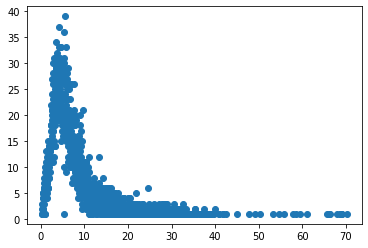

In [95]:
pm25_value_count = df1['PM2.5 particulate matter (Hourly measured)'].value_counts()
print((pm25_value_count > 10).sum())
plt.scatter(pm25_value_count.index, pm25_value_count)


<AxesSubplot:>

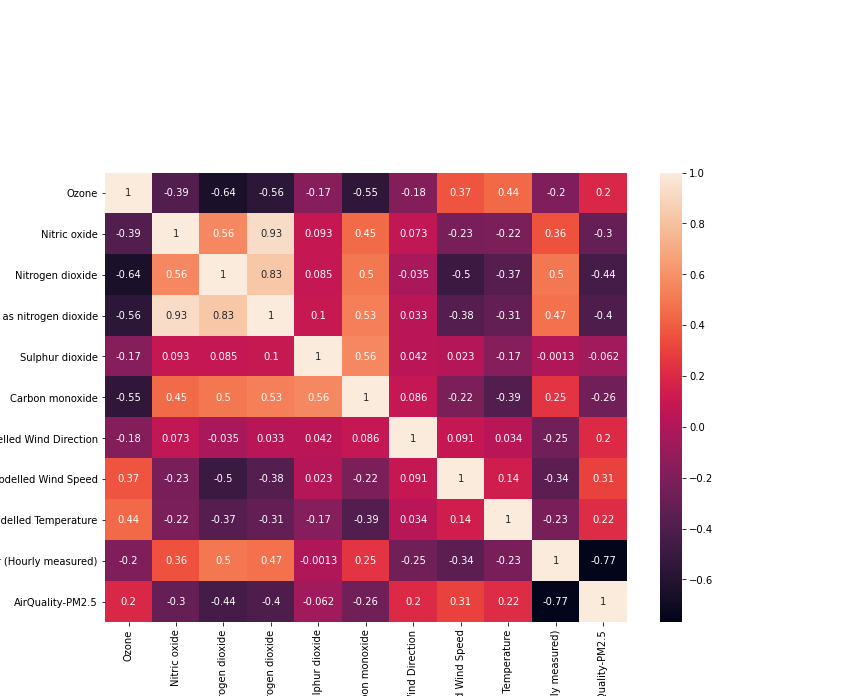

In [41]:
#plot heatmap
a4_dims = (11.7, 8.27)
from matplotlib import pyplot
fig, ax = pyplot.subplots(figsize=a4_dims)
sns.heatmap(ax=ax, data=df1.corr(), annot = True)

### plot PM2.5 particulate matter distribution plot 


<AxesSubplot:xlabel='PM2.5 particulate matter (Hourly measured)', ylabel='Density'>

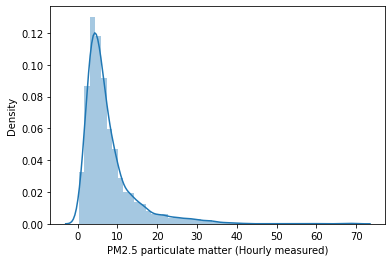

In [88]:
sns.distplot(df1['PM2.5 particulate matter (Hourly measured)'])

## Step 1:  Baseline Model Training and Model Performance Evaluation

- Define X and y
- split train and test set 
- split train dataset again to train and validation set 
- Create a dictionary of classifiers, logistic, knn, svm, and random forest
- Fit and Predict models 
- Calculate evaluation metrics for all models using validation data 
plot ROC curve for each models. 

In [42]:
X = df1.iloc[:, 0:9]
y = df1.iloc[:, -1]
print(f"Xshape: {X.shape}, yshape{y.shape}")
#split data to test set and train set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#split train set again into train set and validation set
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_validation = sc.transform(X_validation)
X_test = sc.transform(X_test)

Xshape: (8224, 9), yshape(8224,)


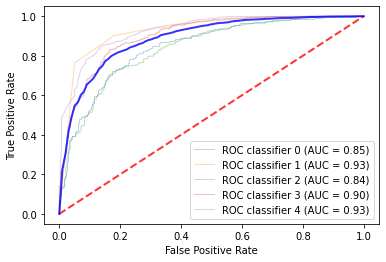

In [66]:
C =10
classifiers = {
    'LogisticR': LogisticRegression(C=C, penalty='l1',
                                      solver='saga',
                                      multi_class='multinomial',
                                      max_iter=10000),
    'KNN': KNeighborsClassifier(algorithm='auto', leaf_size=30,                                                   metric='minkowski',
                                    metric_params=None, n_jobs=None,                                              n_neighbors=5, p=2,
                                    weights='uniform'),
    
    'Linear_SVC': SVC(kernel='linear', C=C, probability=True,
                      random_state=0),
    'rbf_SVC': SVC(kernel='rbf', C=C, probability=True,
                      random_state=0),
    'randomF': RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,                                class_weight=None, criterion='gini', max_depth=None,                         max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42,                               verbose=0,
                       warm_start=False)
   
}
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
fig, ax = plt.subplots()
for idx, (name, classifier) in enumerate(classifiers.items()):
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_validation)
    viz = metrics.plot_roc_curve(classifier, X_validation, y_validation,
                         name='ROC classifier {}'.format(idx),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)
    

#     ax = plt.gca() 
# randomF_disp = metrics.plot_roc_curve(classifier, X_validation, y_validation ,ax=ax,  alpha = 0.8)
# svc_disp.plot(ax=ax, alpha=0.8)
# plt.show()

## Step 2: Model Selection 

Select the model that has highest AUC score 

## Step 3: Hyperparameter optimization
- Use GridSearch CV for hyperparameter optimization 
- Create a parameter Grid dictionary
- Fit the model
- Find best parameters
- find best grids 
- calculate grid accuracy

In [44]:
param_grid = { 
    'max_depth':[10,80,90,100,110, 150],
    'max_features' :[2, 3],
    'min_samples_leaf':[1, 2, 3, 5],
    'min_samples_split':[8 , 10 , 12 ],
    'n_estimators':[ 100 , 200 , 300 , 600]
                     
    
}

randomF = RandomForestClassifier()
grid_search = GridSearchCV(estimator=randomF, param_grid=param_grid, cv=4, n_jobs= -1, verbose=2)
grid_search.fit(X_train, y_train)
grid_search.best_params_
best_grid =grid_search.best_estimator_





Fitting 4 folds for each of 576 candidates, totalling 2304 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed: 15.1min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed: 20.9min
[Parallel(n_jobs=-1)]: Done 2304 out of 2304 | elapsed: 24.3min finished


In [48]:
#Model evaluation
# def evaluate(model, X_validation, y_validation):
#     predictions = model.predict(X_validation)
#     errors = abs(predictions - y_validation)
#     mape = 100 * np.mean(errors / y_validation) #mean absolute percentage error
#     accuracy = 100 - mape
#     print('Model Performance')
#     print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
#     print('Accuracy = {:0.2f}%.'.format(accuracy))
    
#     return accuracy

# base_model = RandomForestClassifier(n_estimators = 10, random_state = 42)
# base_model.fit(X_train, y_train)
# base_accuracy = evaluate(base_model, X_train, y_train)

# grid_accuracy = evaluate(best_grid, X_validation, y_validation)
# print( f" Improvement : of {100*( grid_accuracy-base_accuracy)/ base_accuracy}")

Model Performance
Average Error: 0.1201 degrees.
Accuracy = -inf%.
Model Performance
Average Error: 0.1163 degrees.
Accuracy = -inf%.
 Improvement : of nan


In [49]:
print(grid_search)

GridSearchCV(cv=4, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [10, 80, 90, 100, 110, 150],
                         'max_features': [2, 3],
                         'min_samples_leaf': [1, 2, 3, 5],
                         'min_samples_split': [8, 10, 12],
                         'n_estimators': [100, 200, 300, 600]},
             verbose=2)


In [50]:
print(best_grid)

RandomForestClassifier(max_depth=100, max_features=3, min_samples_split=8,
                       n_estimators=600)


In [63]:
# base_model = RandomForestClassifier(n_estimators = 10, random_state = 42)
# base_model.fit(X_train, y_train)
# base_accuracy = evaluate(base_model, X_validation, y_validation)


In [65]:
# grid_accuracy = evaluate(best_grid, X_validation, y_validation)

In [55]:
grid_score = best_grid.score( X_validation, y_validation)
grid_score

0.8837386018237082

### Model evaluation with validation set 

In [64]:
#Model evaluation with valuation set 
y_pred_val = best_grid.predict(X_validation)
print("RF Accuracy:",metrics.accuracy_score(y_validation, y_pred_val))

print("RF Precision:",metrics.precision_score(y_validation, y_pred_val))
print("RF Recall:",metrics.recall_score(y_validation, y_pred_val))

RF Accuracy: 0.8837386018237082
RF Precision: 0.8961504028648165
RF Recall: 0.964354527938343


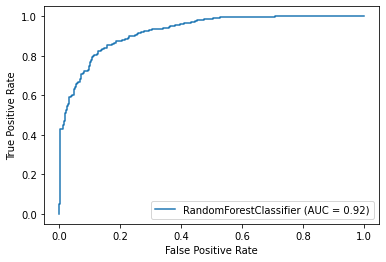

In [71]:
rf_disp_val = metrics.plot_roc_curve(best_grid, X_validation, y_validation) 

In [57]:
y_pred = best_grid.predict(X_test)

### Model performance evaluation with test set 

In [58]:
print("RF Accuracy:",metrics.accuracy_score(y_test, y_pred))

print("RF Precision:",metrics.precision_score(y_test, y_pred))
print("RF Recall:",metrics.recall_score(y_test, y_pred))

RF Accuracy: 0.8905775075987842
RF Precision: 0.9069264069264069
RF Recall: 0.9610091743119266


In [60]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,208,129,337
1,51,1257,1308
All,259,1386,1645


In [61]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.62      0.70       337
           1       0.91      0.96      0.93      1308

    accuracy                           0.89      1645
   macro avg       0.86      0.79      0.82      1645
weighted avg       0.89      0.89      0.89      1645



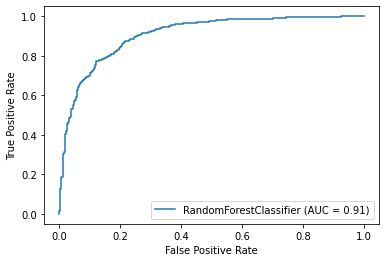

In [59]:
rf_disp = metrics.plot_roc_curve(best_grid, X_test, y_test) 

In [90]:
importances = best_grid.feature_importances_
print(importances)

[0.15092443 0.09686242 0.15310263 0.14113437 0.06762345 0.09762947
 0.12394994 0.07704024 0.09173305]


Feature ranking:
1. feature 2 (0.153103)
2. feature 0 (0.150924)
3. feature 3 (0.141134)
4. feature 6 (0.123950)
5. feature 5 (0.097629)
6. feature 1 (0.096862)
7. feature 8 (0.091733)
8. feature 7 (0.077040)
9. feature 4 (0.067623)


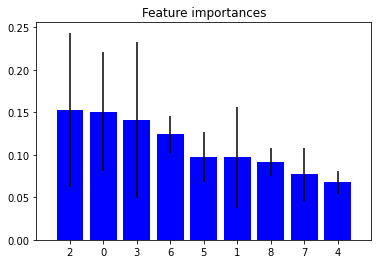

In [92]:
std = np.std([tree.feature_importances_ for tree in best_grid.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        color="b", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [70]:
1 =  pm2.5 <10 low pollution 
0 =  pm2.5 >10 high pollution 
CFP= # getting it right, for any cases of negative, quality adjusted life years
CTN=
CFN=
CTP = 
prevalance= y_test.mean()
print(prevalance)
m = ((1-prevalance)/prevalance)*((CFP - CTN)/(CFN-CTP))

SyntaxError: invalid syntax (<ipython-input-70-5c11f3ed9221>, line 1)